# Разглеждане на дата сет, трениране на модел и оптимизиране

Тук ще опитаме да видим малко "machine learning на практика". Ще разгледаме набор от данни от Kaggle, ще си поиграем с него и ще се опитаме да направим регресор, който да вади добри резултати. Идеята е да видим как изглежда процеса на решаване на реален проблем.

Нека да започнем с малко библиотеки:

In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Може да изтеглите данните с които ще работим от тук:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Трябат ви поне `train.csv` и `test.csv`, които да поставите в `data/house-prices` спрямо директорията в която е notebook-а.

### Да заредим данните и да погледнем какво имаме:

In [2]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

Нека да видим каква е формата на данните. Атрибутът `shape` връща размерността на данните (редове и колони).

In [3]:
print('train:', train.shape)
print('test:', test.shape)

train: (1460, 80)
test: (1459, 79)


В test има една колона по-малко. Нека да видим коя е:

In [4]:
print('missing column:', set(train.columns) - set(test.columns))

missing column: {'SalePrice'}


Ще работим с трейн сета. С тестовия няма какво да правим, защото липсва колоната, която предиктваме.

In [5]:
del test
# Това го нямаше на python лекцията. Помага да осовобидм памет, когато ни е нужна. Без да убиваме процеса.

### Трябва да започнем от някъде. 
Да видим какви колони има в трейн сета.

In [6]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Има и файл с обяснения за вскяка колона:

In [7]:
!head -25 data/house-prices/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial


Може да видим статистика какви стойности има в колоната и разпределението им:

In [8]:
print(train.LandContour.value_counts())

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


In [9]:
print(train.Electrical.value_counts())

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [10]:
print(train.Alley.value_counts())

Grvl    50
Pave    41
Name: Alley, dtype: int64


In [11]:
print(train.FullBath.value_counts())

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64


`Pandas` може да показва и графики:

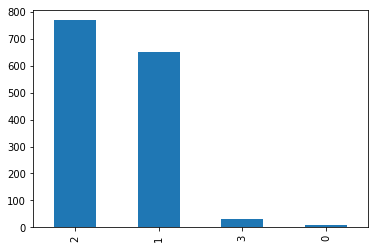

In [12]:
train.FullBath.value_counts().plot(kind='bar');

### Какво ще предсказваме - Цена на имот

Да погледнем какво разпределение иамт данните.

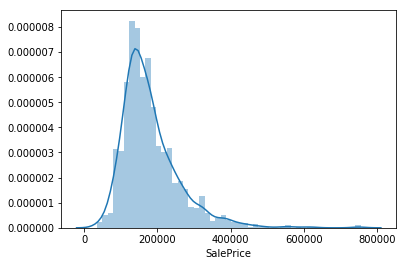

In [13]:
sns.distplot(train.SalePrice);

Ще започнем с *baseline* модел. Идеята е възможно най-бързо да намерим отправна точка, която да подобряваме.

Първо трябва да разедлим данните на `x_train`, `y_train` и `x_test` и `y_test` за да проверим дали моделът генерализира.

In [14]:
from sklearn.model_selection import train_test_split

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=4330)

Дали не сме забравили какво връща `train_test_split`? Нека видим какви размери имат новите променливи:

In [15]:
for df in [x_train, x_test, y_train, y_test]:
    print(df.shape)

(1022, 79)
(438, 79)
(1022,)
(438,)


Нека започнем с линейна регресия:

In [16]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train, y_train)

ValueError: could not convert string to float: 'Abnorml'

# WTF? Анормално?

В този момент идва мега шефа – супер дейта сцайънтист и казва: Събирай си багажа и да те няма! :D

Някой трябва да дебъгва.

In [17]:
print((x_train.values == 'Abnorml').sum())

col_idx = pd.np.argmax(x_train.values == 'Abnorml', axis=1).max()

x_train.iloc[:, col_idx].value_counts()

76


Normal     825
Partial     96
Abnorml     76
Family      16
Alloca       7
AdjLand      2
Name: SaleCondition, dtype: int64

Проблемът е че не можем директно да вкараме текстови стойности в модела.

Как най-лесно да вземем всички числови стойности? `pandas` има метод `describe()`, който показва статистика за колоните с числови стойности.

In [18]:
x_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1022.000000,851.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1018.000000,1022.000000,1022.000000,...,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,58.414873,70.177438,10735.380626,6.073386,5.545988,1971.486301,1984.690802,105.416503,443.613503,45.534247,...,478.014677,91.718200,48.040117,21.546967,3.934442,14.780822,3.440313,39.080235,6.277886,2007.829746
std,44.416250,26.131482,11344.844137,1.373991,1.096401,30.262989,20.737629,181.973221,464.425961,155.139109,...,212.612947,125.674902,68.896801,58.997097,32.831010,55.423160,45.265717,335.892594,2.731375,1.333798
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7564.250000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,...,338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9544.500000,6.000000,5.000000,1972.500000,1993.500000,0.000000,380.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2001.000000,2004.000000,168.750000,719.750000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,318.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


Може да конфигурираме pandas да показва повече колони и редове:

In [19]:
pd.options.display.max_columns = 36
pd.options.display.max_rows = 10

Ще вземем числовите колони по относително мързелив начин, ползвайки резултата от `describe`:

In [20]:
numeric_column_names = x_train.describe().columns
print(numeric_column_names)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


Да потренираме отново

In [21]:
regressor.fit(x_train[numeric_column_names], y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Е, нали ML беше лесен, хвърлям данните на модела или невронната мрежа и готово.

Ще подълбаем още, за да открием модела:

In [22]:
x_train[numeric_column_names].isnull().sum().sort_values()

MSSubClass        0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
               ... 
BsmtFinSF2        0
YrSold            0
MasVnrArea        4
GarageYrBlt      49
LotFrontage     171
dtype: int64

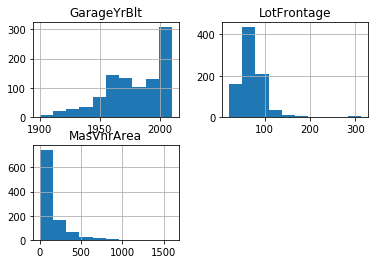

In [23]:
x_train[['LotFrontage','GarageYrBlt', 'MasVnrArea']].hist();

В горния пример слагаме `;` за да не се отпечата върнатата стойност на `hist()` в notebook-а. Правим го за да е по-прегледно. В Python няма нужда от `;` иначе.

По някакъв начин трябва да се отървем от празните стойности. Ето няколко варианта:

- Да премахнем целите редове.
- Да ги заменим със средната стойност или медианата на съответната колона. 
- Да направим ML модел, с който да предвидим колоната с липсващи елементи, на база на останалите колони.

В нашия случай ще ги заменим с 0, защото е подходящо с тези данни. И е най-бързо.

In [24]:
x_train[numeric_column_names] = x_train[numeric_column_names].fillna(0)

/Users/aquarius/.pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Не обръщайте внимание на warning-а. В този случай е ОК и когато говорим за pandas по-натам ще стане по-ясно защо се случва. Може да намерите хубав tutorial по въпроса тук:

https://www.dataquest.io/blog/settingwithcopywarning/

In [25]:
x_train[numeric_column_names].isnull().sum(axis=0).value_counts()

0    36
dtype: int64

### Да потренираме отново...



**third time's a charm**

Proverb definition:<br>
> One is sure to succeed at a task or event on the third try.
>
> May jokingly be extended to fourth, fifth or higher numbers if success is not achieved on the third try.



In [26]:
regressor.fit(x_train[numeric_column_names], y_train)

/Users/aquarius/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Успех!


Следва да видим какво е научил:

In [27]:
regressor.score(x_train[numeric_column_names], y_train)

0.79812636653033908

Някакво число. При максимум 1 - не е зле.

Все пак, какво предсказва? Нека да видим как са разпределени предвижданията:

[  94546.59021574  319548.43264951  140270.63909417  224453.01768405
  236313.23539591  164261.63064394   86677.32797051  254333.97137668]


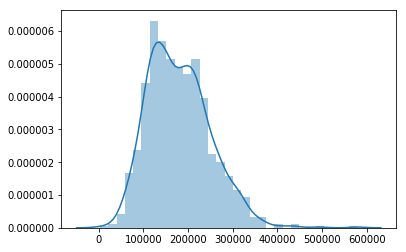

In [28]:
predictions = regressor.predict(x_train[numeric_column_names])

print(predictions[:8])

sns.distplot(predictions);

Може да видим и как е разпределена грешката спрямо стойностите, които трябва да предвидим:

In [29]:
differences = (predictions - y_train).round(0)
print(differences[:8])

Id
128      7547.0
878    -30452.0
880      3771.0
163      4453.0
1181   -13687.0
853       262.0
77     -49073.0
603     34334.0
Name: SalePrice, dtype: float64


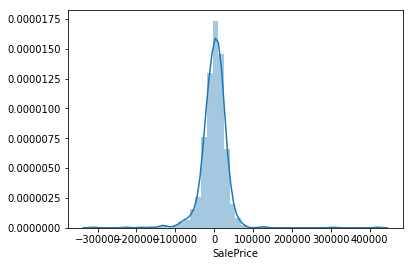

In [30]:
sns.distplot(differences);

Може да видим отклоненията между това което сме предвидили и резултата, който е трябвало да ползнаем:

In [31]:
1 - predictions / y_train

Id
128    -0.086742
878     0.087004
880    -0.027624
163    -0.020241
1181    0.054747
          ...   
1114   -0.025753
796    -0.112036
832    -0.006137
79      0.216790
57     -0.325502
Name: SalePrice, dtype: float64

`predictions / y_train` ще бъде 1 ако сме познали съвсем точно. `1 - predictions / y_train` ще ни върне отклонението в процент.

Може да начертаем същото нещо на диаграма:

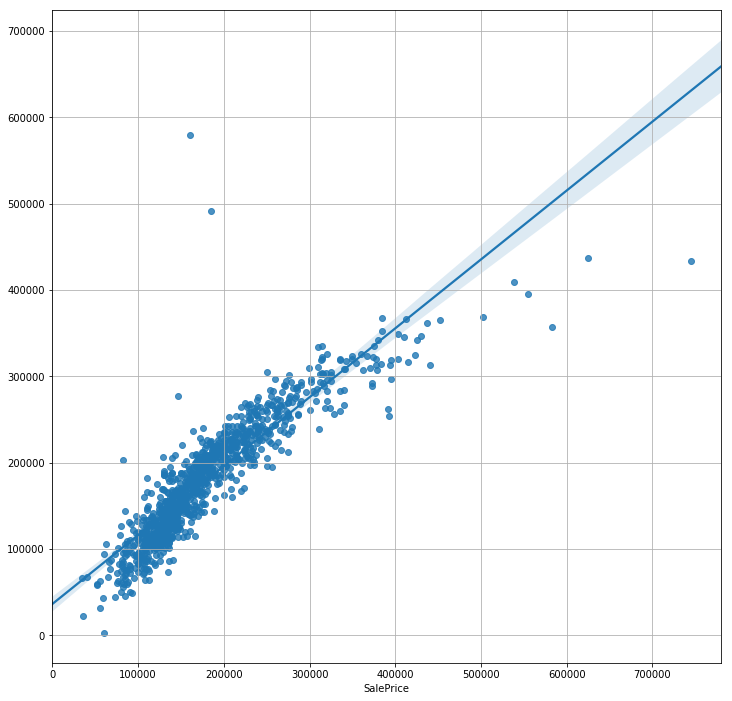

In [32]:
plt.figure(figsize=(12,12))
sns.regplot(y_train, predictions)
plt.grid(True)
plt.show()

По x имаме оригиналната цена, а по y – нашето предвиждане. Ако моделът ни познаваше съвсем точно, всички точко щяха да лежат на правата. Тук може да видим разликите грешката, която правим.

Нека да пробваме с тест сета:

In [33]:
x_test[numeric_column_names].isnull().sum().sort_values(ascending=False)[:4]

LotFrontage    88
GarageYrBlt    32
MasVnrArea      4
YrSold          0
dtype: int64

In [34]:
x_test[numeric_column_names] = x_test[numeric_column_names].fillna(0)

/Users/aquarius/.pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


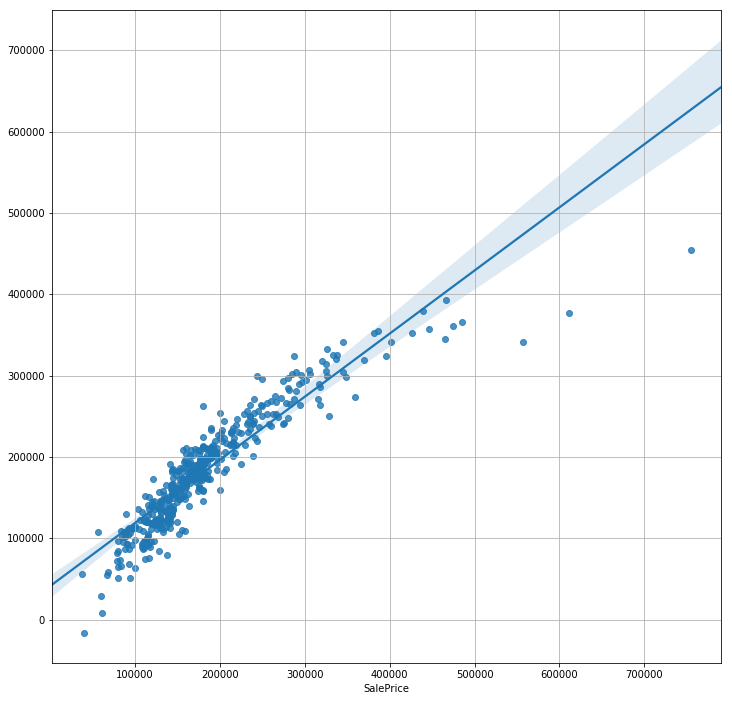

In [35]:
predictions_test = regressor.predict(x_test[numeric_column_names])
plt.figure(figsize=(12,12))
sns.regplot(y_test, predictions_test)
plt.grid(True)
plt.show()

In [36]:
print("score for test:", regressor.score(x_test[numeric_column_names], y_test))

score for test: 0.841202121302


In [37]:
y_test - predictions_test

Id
479      5382.377918
1129    -2325.205851
385    -14341.154261
1123    37918.467438
1217   -40212.464529
            ...     
648    -14056.862212
184    -23378.329871
800     10477.722516
365     -9039.899706
1175    37648.816435
Name: SalePrice, dtype: float64

In [38]:
deviation = 1 - predictions_test / y_test
deviation[:8]

Id
479     0.018122
1129   -0.010815
385    -0.059755
1123    0.338558
1217   -0.359040
1426   -0.134347
1419    0.051172
19     -0.007233
Name: SalePrice, dtype: float64

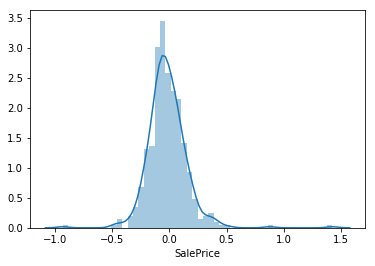

In [39]:
sns.distplot(deviation)

Какво научи модела? Теглата (weights) на всеки един от атрибутите. Нека го визуализираме:

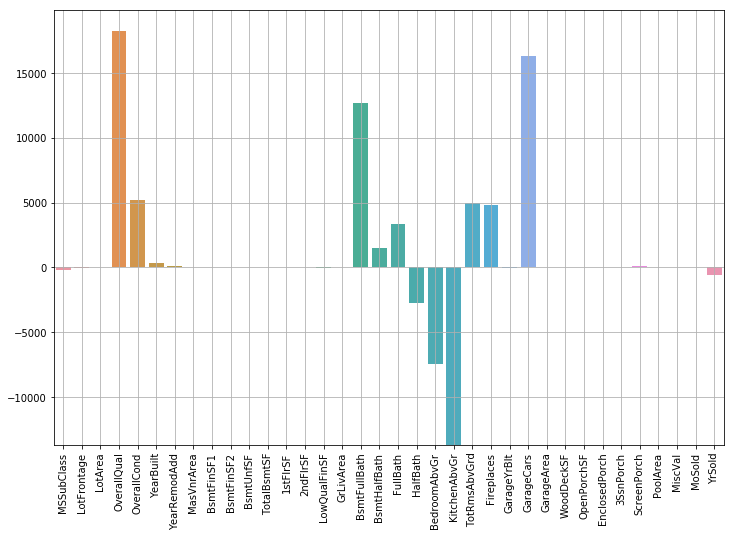

In [40]:
plt.figure(figsize=(12,8))
barplot = sns.barplot(x=numeric_column_names, y=regressor.coef_, orient='vertical')
plt.setp(barplot.get_xticklabels(), rotation=90); plt.grid(True);

Тук може да видим някои интересни неща – олоните `OverallQual` и `BsmtFullBath` имат много голяма стойност. Също, наличието на гараж (`GarageCars`) добавя около 16 000 към цената на апартамента.

В крайна сметка, линейната регресия е просто линейно уравниение с определени коефициенти (тези горе). Може да ги видим в самия регресор:

In [41]:
print(regressor.intercept_)
print(regressor.coef_)

55884.0271212
[ -1.74092382e+02  -1.59334956e+01   3.90604746e-01   1.82477174e+04
   5.21657989e+03   3.75326569e+02   1.36580705e+02   2.17291147e+01
   6.20814805e+00   7.67033274e-03  -6.04172067e-01   5.61164632e+00
   1.99827845e+01   2.17552995e+01  -2.43299134e+01   1.74081705e+01
   1.26936626e+04   1.50351700e+03   3.33729642e+03  -2.70834376e+03
  -7.47762034e+03  -1.36774474e+04   4.95468307e+03   4.80689715e+03
  -1.46397401e+01   1.62721482e+04   6.62093154e+00   3.00251352e+01
   3.95602564e+00   3.05792346e+01   4.55257238e+01   7.31855496e+01
  -6.40235362e+00  -2.58236600e+00   2.66355805e+01  -5.50741893e+02]


Модела в момента:

цена = 56000 + 17000 \* _OverallQual_ + 16000 \* _GarageCars_ + 12000 \* _BsmtFullBath_ - 14000 \* _KitchenAbvGr_

$y = a_0 + a_1 * x_1 + a_2 * x_2 ... a_n * x_n$

In [42]:
print(regressor.intercept_, " + ",)
list(zip(regressor.coef_, "*"*len(regressor.coef_), numeric_column_names, ))

55884.0271212  + 


[(-174.09238201319431, '*', 'MSSubClass'),
 (-15.933495614894447, '*', 'LotFrontage'),
 (0.39060474565805725, '*', 'LotArea'),
 (18247.717407531465, '*', 'OverallQual'),
 (5216.5798941718949, '*', 'OverallCond'),
 (375.32656942572908, '*', 'YearBuilt'),
 (136.58070545805526, '*', 'YearRemodAdd'),
 (21.729114669057438, '*', 'MasVnrArea'),
 (6.2081480519034233, '*', 'BsmtFinSF1'),
 (0.0076703327361258289, '*', 'BsmtFinSF2'),
 (-0.60417206708136995, '*', 'BsmtUnfSF'),
 (5.6116463169440927, '*', 'TotalBsmtSF'),
 (19.982784461262582, '*', '1stFlrSF'),
 (21.755299479711027, '*', '2ndFlrSF'),
 (-24.329913407074798, '*', 'LowQualFinSF'),
 (17.408170535950532, '*', 'GrLivArea'),
 (12693.662631968591, '*', 'BsmtFullBath'),
 (1503.5170040009152, '*', 'BsmtHalfBath'),
 (3337.2964235028926, '*', 'FullBath'),
 (-2708.3437562699974, '*', 'HalfBath'),
 (-7477.620342120892, '*', 'BedroomAbvGr'),
 (-13677.447367546698, '*', 'KitchenAbvGr'),
 (4954.6830722139875, '*', 'TotRmsAbvGrd'),
 (4806.897153734045

## До тук:

* Разделихме данните на тренировъчно и тестово множество.
* Взехме само числовите колони.
* Изчистихме (земенихме с 0) празните стойности.
* Натренирахме регресор.
* Изчислихме му резултата - за трейн: 0.798 за тест: 0.8412021
* Определихме, че моделът не овървфитва - генерализира добре. Следователно може да бъде използван по-сложен модел.
* Използваните от модела фичъри не изглеждат интуитивно оптимални.
* Разгледахме разликите в предвижданията на цените за трейн и тест множествата.
* Разгледахме теглата на фичърите.

## Следва

* Усложняване на модела – още фичъри от данните.

In [43]:
pd.options.display.max_rows = 10
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
dtype: object

In [44]:
categorical_columns = train.dtypes[train.dtypes == 'object'].index
print(categorical_columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


Би било добре.... да разгледаме какво съдържат всички колони, но... 

![какво е ML](https://imgs.xkcd.com/comics/machine_learning.png)

### Как да използваме данните от останалите колони? 

Hint: Трябва да ги умножаваме с тегла – трябва да са числови стойности, а не низове.

Може да ползваме нещо, наречено [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). То ще замени замени всеки уникален низ с число.

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])

print("Learned classes:", le.classes_)

capitals_list = ["tokyo", "tokyo", "paris"]

print("transofrmed:", capitals_list, " to:", le.transform(["tokyo", "tokyo", "paris"])) 
print("inverse:", [2, 2, 1, 0], " to:", le.inverse_transform([2, 2, 1, 0]))

Learned classes: ['amsterdam' 'paris' 'tokyo']
transofrmed: ['tokyo', 'tokyo', 'paris']  to: [2 2 1]
inverse: [2, 2, 1, 0]  to: ['tokyo' 'tokyo' 'paris' 'amsterdam']


Тук обаче имаме проблем.

Ако теглото за столица е 4. Тогава Амстердам ще има стойност `4 * 0 = 0`, а Париж `4 * 1 = 4`.
    
Но според Лъчо, `Амстердамския кекс > Парижкия кроасан`.

Тук може да ни помогне `OneHotEncoder`. Той ще създаде по една колона за всяка стойност, която ще бъде `0` или `1` спрямо дали колоната има тази стойност или не:

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc.fit([[0, 0, 3], 
         [1, 1, 0], 
         [0, 2, 1], 
         [1, 0, 2]])

print("Number of unique IDs for column:", enc.n_values_)
print("Where does the feature start/end:", enc.feature_indices_)
print(enc.transform([[0, 1, 1]]).toarray())
print(enc.transform([[1, 2, 3]]).toarray())

Number of unique IDs for column: [2 3 4]
Where does the feature start/end: [0 2 5 9]
[[ 1.  0.  0.  1.  0.  0.  1.  0.  0.]]
[[ 0.  1.  0.  0.  1.  0.  0.  0.  1.]]


Обаче LabelEncoder работи само с 1 колона. Трябва да ги завъртим в цикъл за всички колони.

In [47]:
train = train.fillna("")
encoders = {col: LabelEncoder().fit(train[col]) for col in categorical_columns}

print(encoders['MSZoning'].classes_)
print(encoders['Street'].classes_)

['C (all)' 'FV' 'RH' 'RL' 'RM']
['Grvl' 'Pave']


Сега ще промерим низивете към новите идентификатори:

In [48]:
def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

train_encoded = encode_categorical(train, categorical_columns, encoders)

pd.options.display.max_columns=12
train_encoded.head(8)

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,...,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,
1,0,0,4,4,3,6,...,1,1,4,8,1,0
2,0,0,4,2,1,6,...,1,1,4,8,1,0
3,0,0,4,3,3,6,...,1,1,4,8,1,0
4,0,0,2,4,1,6,...,1,1,0,8,1,0
5,0,0,4,1,3,6,...,1,1,4,8,1,0
6,0,0,4,4,3,6,...,1,1,4,8,1,0
7,0,0,4,1,3,6,...,1,1,4,8,1,0
8,0,0,4,3,1,2,...,1,1,4,8,1,0


И сега в one-hot:

In [49]:
one_hot_encoder = OneHotEncoder().fit(train_encoded)

print(one_hot_encoder.transform(train_encoded[:10]).todense())
print(one_hot_encoder.transform(train_encoded).shape)

[[ 1.  0.  0. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  1.  1.  0.]
 ..., 
 [ 1.  0.  0. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  1.  1.  0.]]
(1460, 268)


### Да натренираме... регресор само с тези данни

In [50]:
from sklearn.linear_model import LinearRegression 

one_hot_x_train = one_hot_encoder.transform(encode_categorical(x_train[categorical_columns], categorical_columns, encoders))

cat_regression = LinearRegression().fit(one_hot_x_train, y_train)
print(cat_regression.score(one_hot_x_train, y_train))

one_hot_x_test = one_hot_encoder.transform(encode_categorical(x_test[categorical_columns], categorical_columns, encoders))
print(cat_regression.score(one_hot_x_test, y_test))

0.877046842196
0.743049977138


Предишните резултати за трейн: 0.798 за тест: 0.841

Новите са: 0.877 и 0.743

Този модел овърфитва, но пак има стойност. Можем да съединим фичърите в общ модел.

In [51]:
x_train[numeric_column_names].shape, one_hot_x_train.shape

((1022, 36), (1022, 268))

In [52]:
new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_column_names]], axis=1)
new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[numeric_column_names]], axis=1)
print(new_x_train.shape, new_x_test.shape)

(1022, 304) (438, 304)


### Да потренираме... отново

Това почва да омръзва вече :D

In [53]:
all_data_lr = LinearRegression().fit(new_x_train, y_train)
print(all_data_lr.score(new_x_train, y_train))
print(all_data_lr.score(new_x_test, y_test))

0.93747736618
0.846888152428


0.798 за тест: 0.841

0.877 и 0.743

Новите: 0.937, за тест: 0.847 
**(голямо подобрение за трейн и малко за тест сета)**

Да пробваме регуларизация

In [54]:
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(new_x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(new_x_train, y_train), all_data_lr.score(new_x_test, y_test))
    print()

alpha: 0.01
0.937460717713 0.848821474014

alpha: 0.1
0.936445464242 0.859628242827

alpha: 1
0.922736065601 0.882426715999

alpha: 10
0.893310713513 0.892240478482

alpha: 100
0.852442428875 0.882169210027



Новите резултати при alpha= 10:

трейн: 0.893310713513

тест: 0.892240478482

Модела е доста по-добър и генерализира добре. Може и да изтиска още малко ако се търси в диапазона 0.1 до 100 на alpha.

### Още една трансформация (feature engineering)

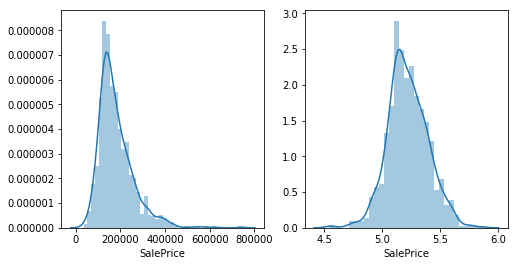

In [55]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.distplot(y_train)
plt.subplot(1, 2, 2)
sns.distplot(pd.np.log10(y_train))

Тук имаше малко магия – първата дистрибуция ила long-tail форма. Понякога като прекараме такава дистрибуция през логаритъм, тя започва да изглежда по-стандартно. В случая (произволно) избрахме логаритъм при основа 10, което свежда нещата до що-годе стандартна дистрибуция.

In [56]:
all_data_lr = LinearRegression().fit(new_x_train, pd.np.log10(y_train))
print(all_data_lr.score(new_x_train, pd.np.log10(y_train)))
print(all_data_lr.score(new_x_test, pd.np.log10(y_test)))

# Предишни резултати: 
# трейн: 0.893310713513
# тест: 0.892240478482

0.944010274337
0.897071352655


Вече имаме по-добри резултати.

Изглежда, обаче, че модела overfit-а. Може да пробваме с регуляризация. Нека да потърсим подходящ `alpha` параметър:

In [57]:
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    all_data_lr = Ridge(alpha = alpha).fit(new_x_train, pd.np.log10(y_train))
    print('alpha:', alpha)
    print(all_data_lr.score(new_x_train, pd.np.log10(y_train)), all_data_lr.score(new_x_test, pd.np.log10(y_test)))
    print()

alpha: 0.01
0.943997501252 0.898373694962

alpha: 0.1
0.943229831719 0.905995893636

alpha: 1
0.934194754485 0.918658732499

alpha: 10
0.914572813642 0.925776887973

alpha: 100
0.885671673021 0.922058006344



In [58]:
from sklearn.metrics import r2_score

for alpha in [0.01, 0.1, 1, 10, 100]:
    all_data_lr = Ridge(alpha = alpha).fit(new_x_train, pd.np.log10(y_train))
    print('alpha:', alpha)
    print(r2_score(10**all_data_lr.predict(new_x_train), y_train))
    print(r2_score(10**all_data_lr.predict(new_x_test), y_test))
    print()

alpha: 0.01
0.944147892685
0.920031051823

alpha: 0.1
0.942541628143
0.920527643354

alpha: 1
0.926086094333
0.917329215283

alpha: 10
0.879718307165
0.914859971683

alpha: 100
0.781803737598
0.891525074439



In [59]:
print(r2_score(y_train, 10**all_data_lr.predict(new_x_train)))
print(r2_score(y_test, 10**all_data_lr.predict(new_x_test)))

0.81847382341
0.917116396735


alpha: 10

0.914572813642

0.925776887973



Хубава статия за още масажиране на данните: 

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook

### Последно - полиномни

Може да ползваме `PolynomialFeatures` да генерираме всички възможни полиноми от втора степен с входните данни:

In [60]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

poly_features.fit(new_x_train)

poly_x_train = poly_features.transform(new_x_train)
poly_x_test = poly_features.transform(new_x_test)

print(new_x_train.shape)
print(poly_x_train.shape)

(1022, 304)
(1022, 46665)


Нека да видим резултата с различни регуляризации.

In [61]:
for a in [10e6, 10e7, 10e8, 10e9, 10e10]:
    print('alpha:', a)
    all_data_lr = Ridge(alpha=a).fit(poly_x_train, pd.np.log10(y_train))
    print(all_data_lr.score(poly_x_train, pd.np.log10(y_train)), all_data_lr.score(poly_x_test, pd.np.log10(y_test)))
    print()

alpha: 10000000.0
0.987828174178 -0.845823330464

alpha: 100000000.0
0.974980329714 0.556684554405

alpha: 1000000000.0
0.960607069631 0.828562611736

alpha: 10000000000.0
0.940967858172 0.537021309466

alpha: 100000000000.0
0.911468362953 0.51866234456



Този модел прави стабилен overfitting – явно е твърде сложен.

Като правило, когато има повече колони, отколкото редове, това се случва.

### Намерихме модел, да го събмитнем.

In [62]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

def pipeline_data(data):
    _numeric = data[numeric_column_names].fillna(0)
    _categorical = data[categorical_columns].fillna("")
    _encoded = encode_categorical(_categorical, categorical_columns, encoders)
    _one_hot_encoded = one_hot_encoder.transform(_encoded)
    _merged = pd.np.concatenate([_one_hot_encoded.todense(), _numeric], axis=1)
    return _merged

In [63]:
full_x = pipeline_data(train)
full_y = train['SalePrice']

# Fix test set missing data problems
test['MSZoning'].fillna('RL', inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)

test_set = pipeline_data(test)

In [64]:
ridge = Ridge(alpha=0.1).fit(full_x, pd.np.log10(full_y))

In [ ]:
predictions = 10**ridge.predict(test_set)
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("/Users/lachezar/Downloads/submit_me.csv", index=False)
predictions_df.head()

![prediction_result](3-prediction-result.png)

### Защо не съм на по-добро място в класацията?

### Заключения

1. Има ли значение дали правим регресия или класификация?
Ако колоната, която предсказваме съдържа ['скъпа', 'евтина', 'средна']

2. Има ли значение кой модел ползваме - LinearRegression, RandomForest, Neural Network, kNN?

3. Колко кобминации можем да направим за модела?

4. 4 часа разглеждане на данни, чистене и оформяне на pipeline и фичъри. 20 минути трениране и оптимизиране на модели.

### За домашно: 

1. Прочетете документациите

  * http://scikit-learn.org/stable/modules/preprocessing.html
  * https://seaborn.pydata.org/
  * https://pandas.pydata.org/pandas-docs/stable/

2. Упражнение

  Изберете си dataset от https://www.kaggle.com/datasets и му направете "Exploratory data analysis" в jupyter notebook. Изберете си колона и натренирайте Линейна или логистична регресия. Оценете модела срещу тренировачното и тестово множество.